# Quick Chart

This is a workbook for making a single chart. The initial load is all condensed into one cell so the environment can be quickly setup

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
import matplotlib
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import zscore
import requests
from datetime import datetime, timedelta
import os
import glob
import json
import pprint

sns.set_theme()
sns.set_context("poster")

# Constants for the API call
API_URL = "https://api.scryfall.com/bulk-data"

# Function to download the default cards file
def download_file(download_uri, filename):
    response = requests.get(download_uri)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded the new file: {filename}")
        return filename
    else:
        print("Failed to download file.")
        return None

# Step 1: Check the directory for the 'default-cards' file
file_pattern = "default-cards*.json"  # Adjust pattern as needed
file_list = glob.glob(file_pattern)
latest_file = None

# Determine the latest file based on the modification time
for file in file_list:
    if latest_file is None or os.path.getmtime(file) > os.path.getmtime(latest_file):
        latest_file = file

data_file = latest_file  # Assume the latest local file is the data file

# If there's no latest file found or it's older than a week, download a new one
if latest_file is None or (datetime.now() - datetime.fromtimestamp(os.path.getmtime(latest_file))) > timedelta(days=7):
    response = requests.get(API_URL)
    if response.status_code == 200:
        bulk_data_info = response.json()
        for entry in bulk_data_info.get("data", []):
            if entry["name"].lower() == "default cards":
                # Found the default cards entry, proceed to download
                filename = entry["download_uri"].split('/')[-1]
                data_file = download_file(entry["download_uri"], filename)
                break
    else:
        print("Failed to retrieve data from the API")
else:
    print(f"The latest data file available is '{data_file}' and it is not a week old yet.")

# Ensure `data_file` is not None and is the latest file
if data_file is None:
    print("No valid data file found or downloaded.")
else:
    print(f"Using the data file: {data_file}")

# At this point, `data_file` will have the name of the latest file

# Load data from the file
df= pd.read_json(data_file)

# Keywords to exclude
excluded_keywords = ["token", "playtest", "scheme", "planechase", "sticker", "art series", "alchemy", "anthology","oversized"]

# Filter out sets based on keywords
df = df[~df['set_name'].str.lower().str.contains('|'.join(excluded_keywords))]

# Handle NaN values in 'oracle_text'
df['oracle_text'] = df['oracle_text'].fillna('')

# Remove sets with fewer than 30 cards
#filtered_sets = df['set_name'].value_counts()
#valid_sets = filtered_sets[filtered_sets >= 30].index
#df = df[df['set_name'].isin(valid_sets)]

# Filtering out rows where set_name starts with "un" (case-insensitive)
df = df[~df['set_name'].str.lower().str.startswith('un')]

# Assuming 'released_at' is a string representing dates, convert to datetime
df['released_at'] = pd.to_datetime(df['released_at'], errors='coerce')

# Drop rows with NaT in 'released_at' if any conversion errors occurred
df = df.dropna(subset=['released_at'])

# Extract year from 'released_at' datetime column
df['release_year'] = df['released_at'].dt.year

# Filter out all data from 2024
df = df[df['release_year'] != 2024]

The latest data file available is 'default-cards-20231106100506.json' and it is not a week old yet.
Using the data file: default-cards-20231106100506.json


In [3]:
display(df.columns)

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id',
       'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang',
       'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'power', 'toughness', 'colors', 'color_identity',
       'keywords', 'legalities', 'games', 'reserved', 'foil', 'nonfoil',
       'finishes', 'oversized', 'promo', 'reprint', 'variation', 'set_id',
       'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri',
       'scryfall_set_uri', 'rulings_uri', 'prints_search_uri',
       'collector_number', 'digital', 'rarity', 'flavor_text', 'card_back_id',
       'artist', 'artist_ids', 'illustration_id', 'border_color', 'frame',
       'full_art', 'textless', 'booster', 'story_spotlight', 'edhrec_rank',
       'penny_rank', 'prices', 'related_uris', 'purchase_uris', 'all_parts',
       'promo_types', 'arena_id', 'security_stamp', 'card_faces'

# Commander Players

Let's look at Commander Data

First filter to only commander sets to see how that has changed.
Fully look at commanders
Blend EDHREC Data?

**Ideas** <br>
How many new commanders per year? <br>
How many commanders printed per year?

Filters

1. Set name contains the word "Commander"
2. Set name does not contain "minigame"
3. Type line does not contain "token"

Dataframes

1. commander_df - Filtered dataframe
2. unique_commander_df - Filtered dataframe with unique cards. Only the earliest printing is kept. This should show reprints
3. df - All cards
4. unique_df - The earliest printing of each card
5. legendary_df = Legendary creatures
6. unique_legendary_df = Legendary creatures with reprints excluded

In [4]:
commander_df = df[df['set_name'].str.contains('commander', case=False, na=False)]
commander_df = commander_df[~commander_df['set_name'].str.contains("minigame", case=False, na=False)]
# Filter rows where 'type_line' contains "token"
commander_df = commander_df[~commander_df['type_line'].str.contains('token', case=False, na=False)]

unique_sets = commander_df['set_name'].unique()

print(f"Unique sets: {len(unique_sets)}")
print(f"Total cards: {len(commander_df)}")
print(f"Total unique cards: {len(commander_df['name'].unique())}")
print(f"Total unique cards with oracle text: {len(commander_df[commander_df['oracle_text'] != '']['name'].unique())}")
print()

# for set_name in unique_sets:
#     print(set_name)

# Sort the DataFrame by 'released_at' in ascending order
unique_commander_df = commander_df.sort_values(by='released_at')

# Drop duplicates based on the 'name' column and keep only the earliest version of each unique name
unique_commander_df = unique_commander_df.drop_duplicates(subset='name', keep='first')

print(f"Total unique cards check: {len(unique_commander_df) == len(commander_df['name'].unique())}")
# Compare the number of unique cards and print the result as a boolean

#print the numebr of cards in "Commander 2011"
print(f"Total cards in Commander 2011: {len(commander_df[commander_df['set_name'] == 'Commander 2011'])}")

Unique sets: 38
Total cards: 10941
Total unique cards: 5031
Total unique cards with oracle text: 4968

Total unique cards check: True
Total cards in Commander 2011: 318


In [5]:
print(df['name'].head())

0            Fury Sliver
1          Kor Outfitter
3          Siren Lookout
4                    Web
5    Surge of Brilliance
Name: name, dtype: object


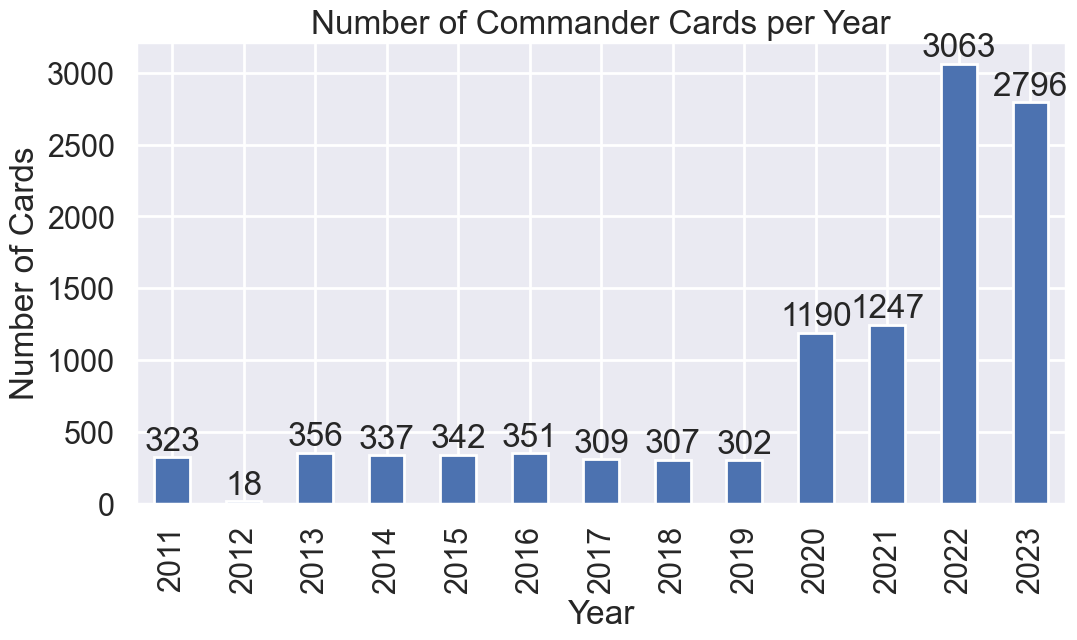

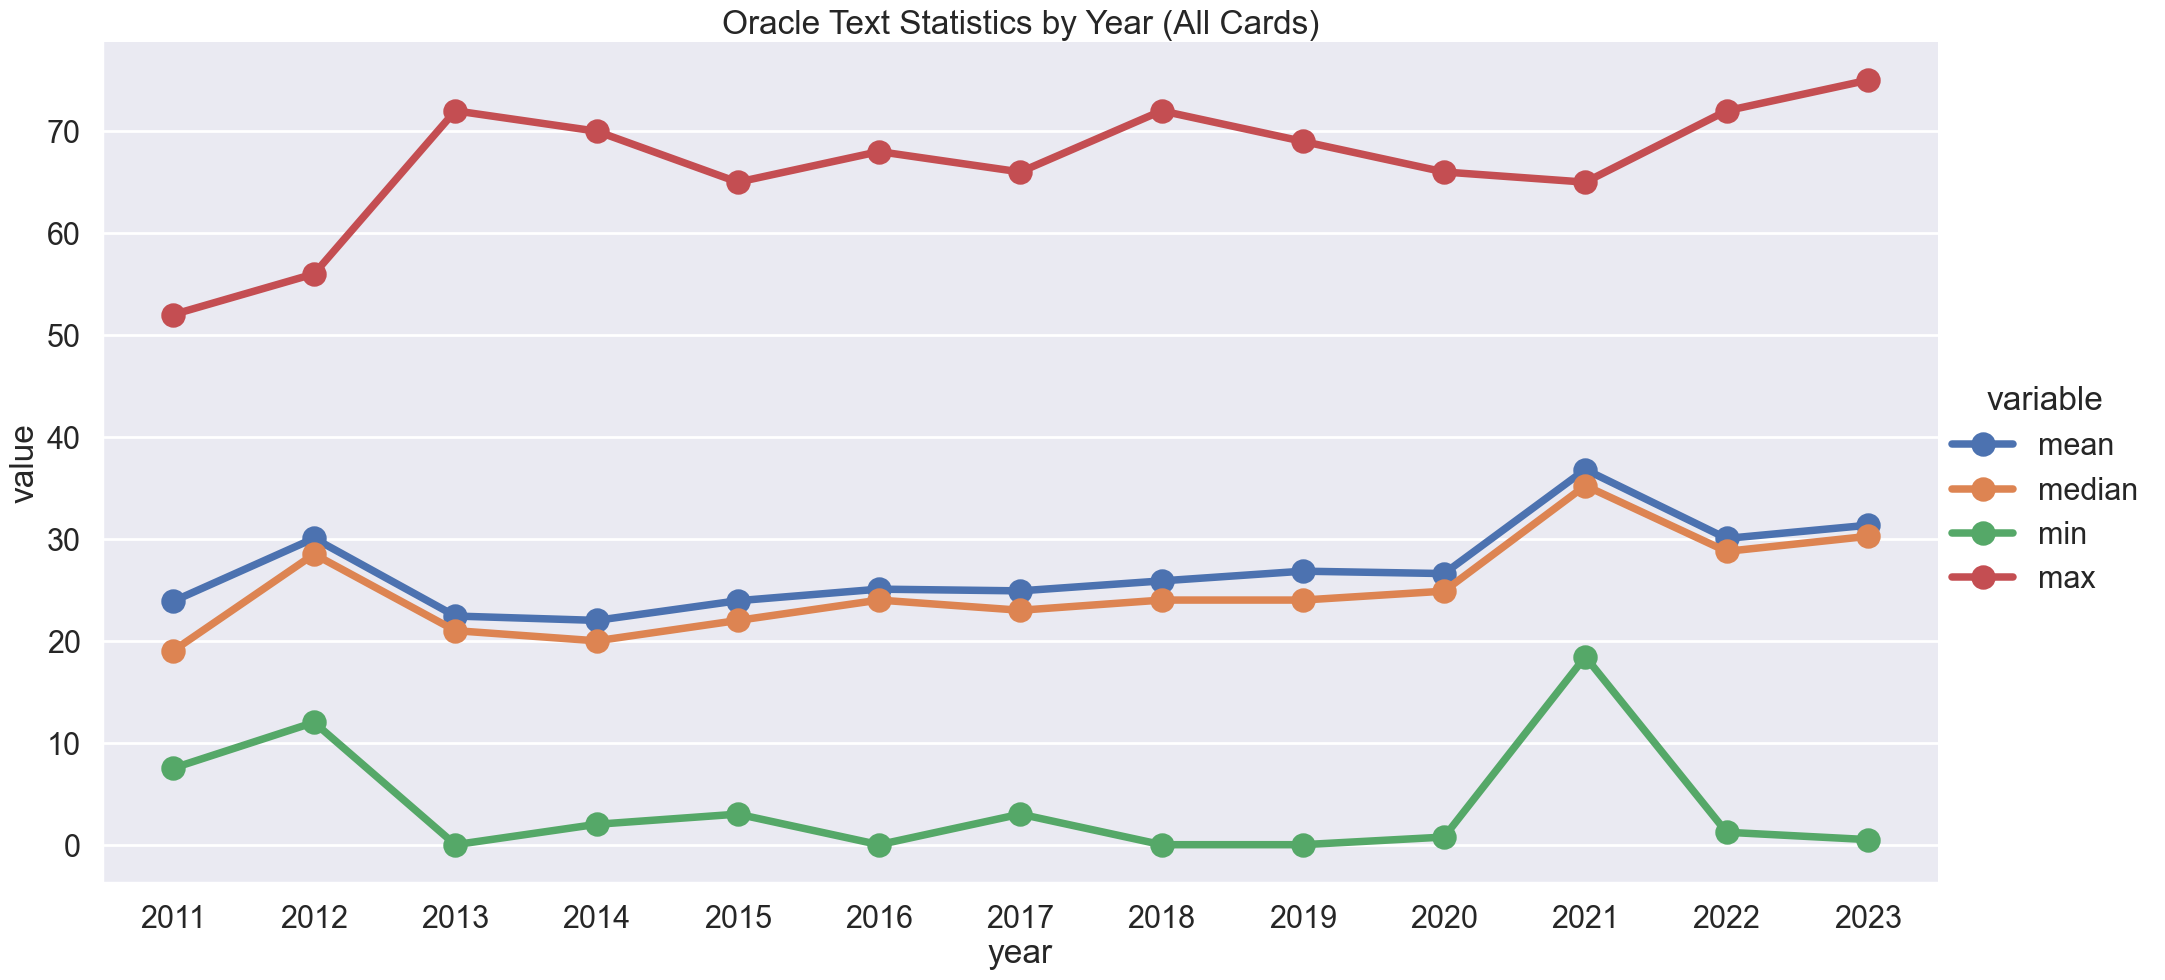

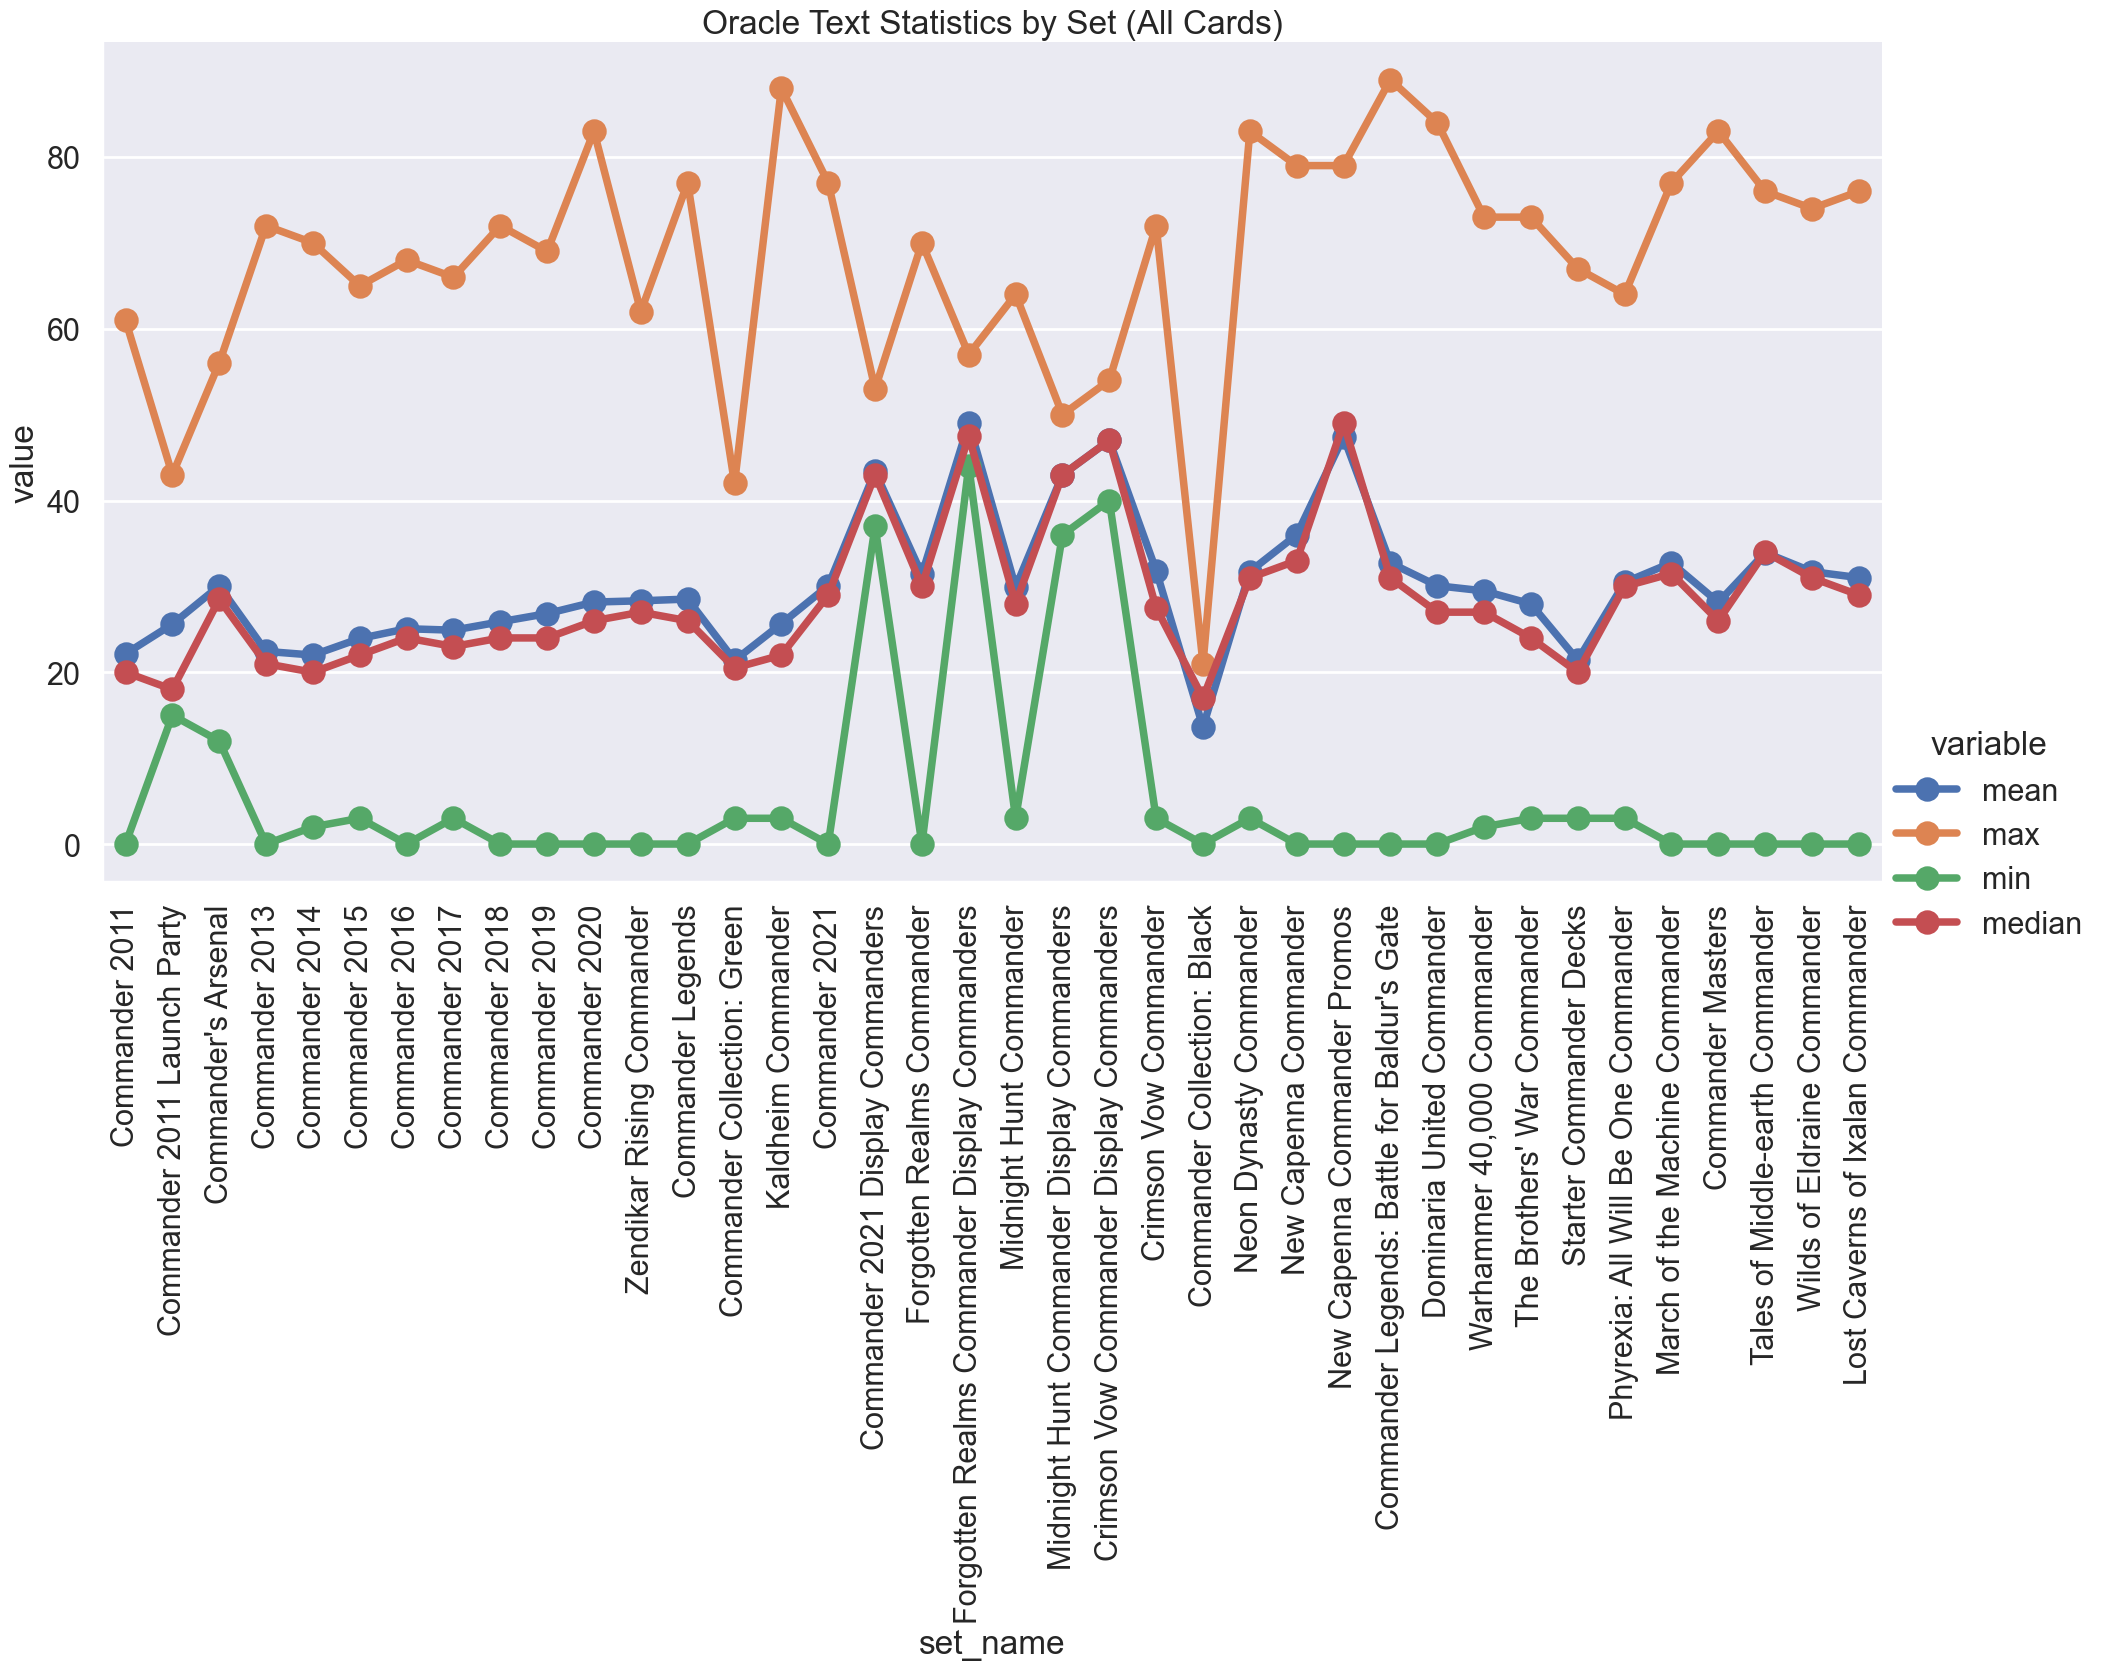

In [6]:
commander_df.loc[:, 'released_at'] = pd.to_datetime(commander_df['released_at'])
commander_df.loc[:, 'year'] = commander_df['released_at'].dt.year

# Group the data by 'year' and get the number of cards in each group
cards_per_year = commander_df.groupby('year').size()

# Create a graph showing the number of cards per year
ax = cards_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Commander Cards per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')

# Add data labels to the bars
for i, v in enumerate(cards_per_year):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.show()

# Count the number of words in each oracle_text
commander_df.loc[:, 'word_count'] = commander_df['oracle_text'].apply(lambda x: len(str(x).split()))

# Group by set and year, and calculate mean, median, min, and max word count
stats = commander_df.groupby(['set_name', 'year'])['word_count'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Reshape the DataFrame for easier plotting
melted_stats = stats.melt(id_vars=['set_name', 'year'], value_vars=['mean', 'median', 'min', 'max'])

# Create a bar plot with 'year' on the x-axis
sns.catplot(data=melted_stats, x='year', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.title('Oracle Text Statistics by Year (All Cards)')
plt.show()

# Merge 'released_at' back into the 'melted_stats' DataFrame
melted_stats = pd.merge(melted_stats, commander_df[['set_name', 'year', 'released_at']].drop_duplicates(), on=['set_name', 'year'], how='left')

# Sort the DataFrame by 'released_at'
melted_stats_sorted = melted_stats.sort_values(by='released_at')

# Create a bar plot with 'set_name' on the x-axis
sns.catplot(data=melted_stats_sorted, x='set_name', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Oracle Text Statistics by Set (All Cards)')
plt.show()

----

 Now lets do it again with reprints removed

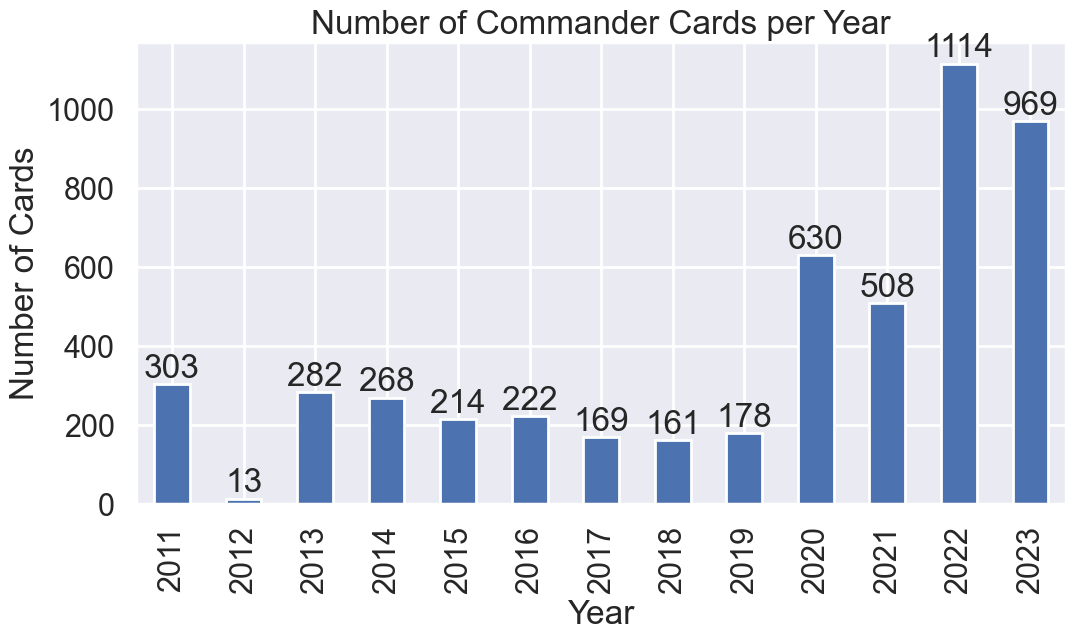

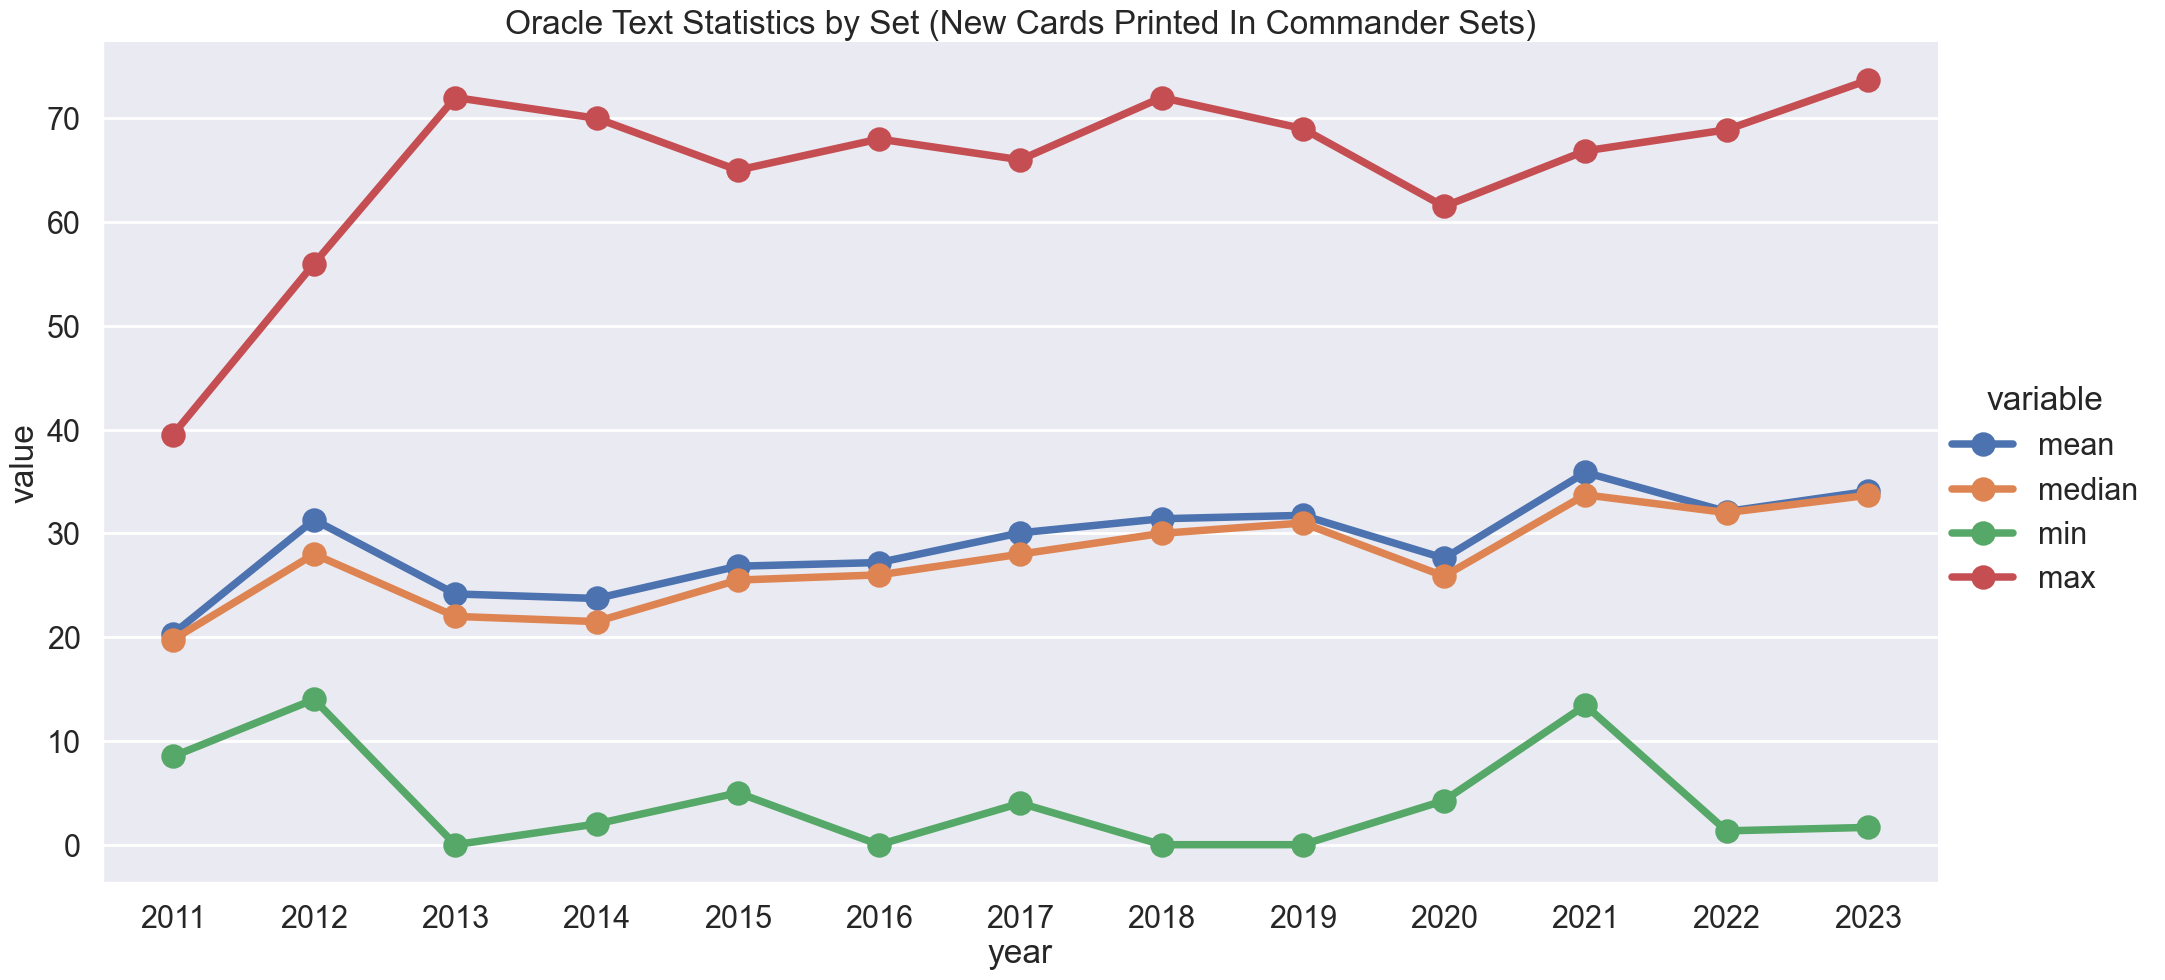

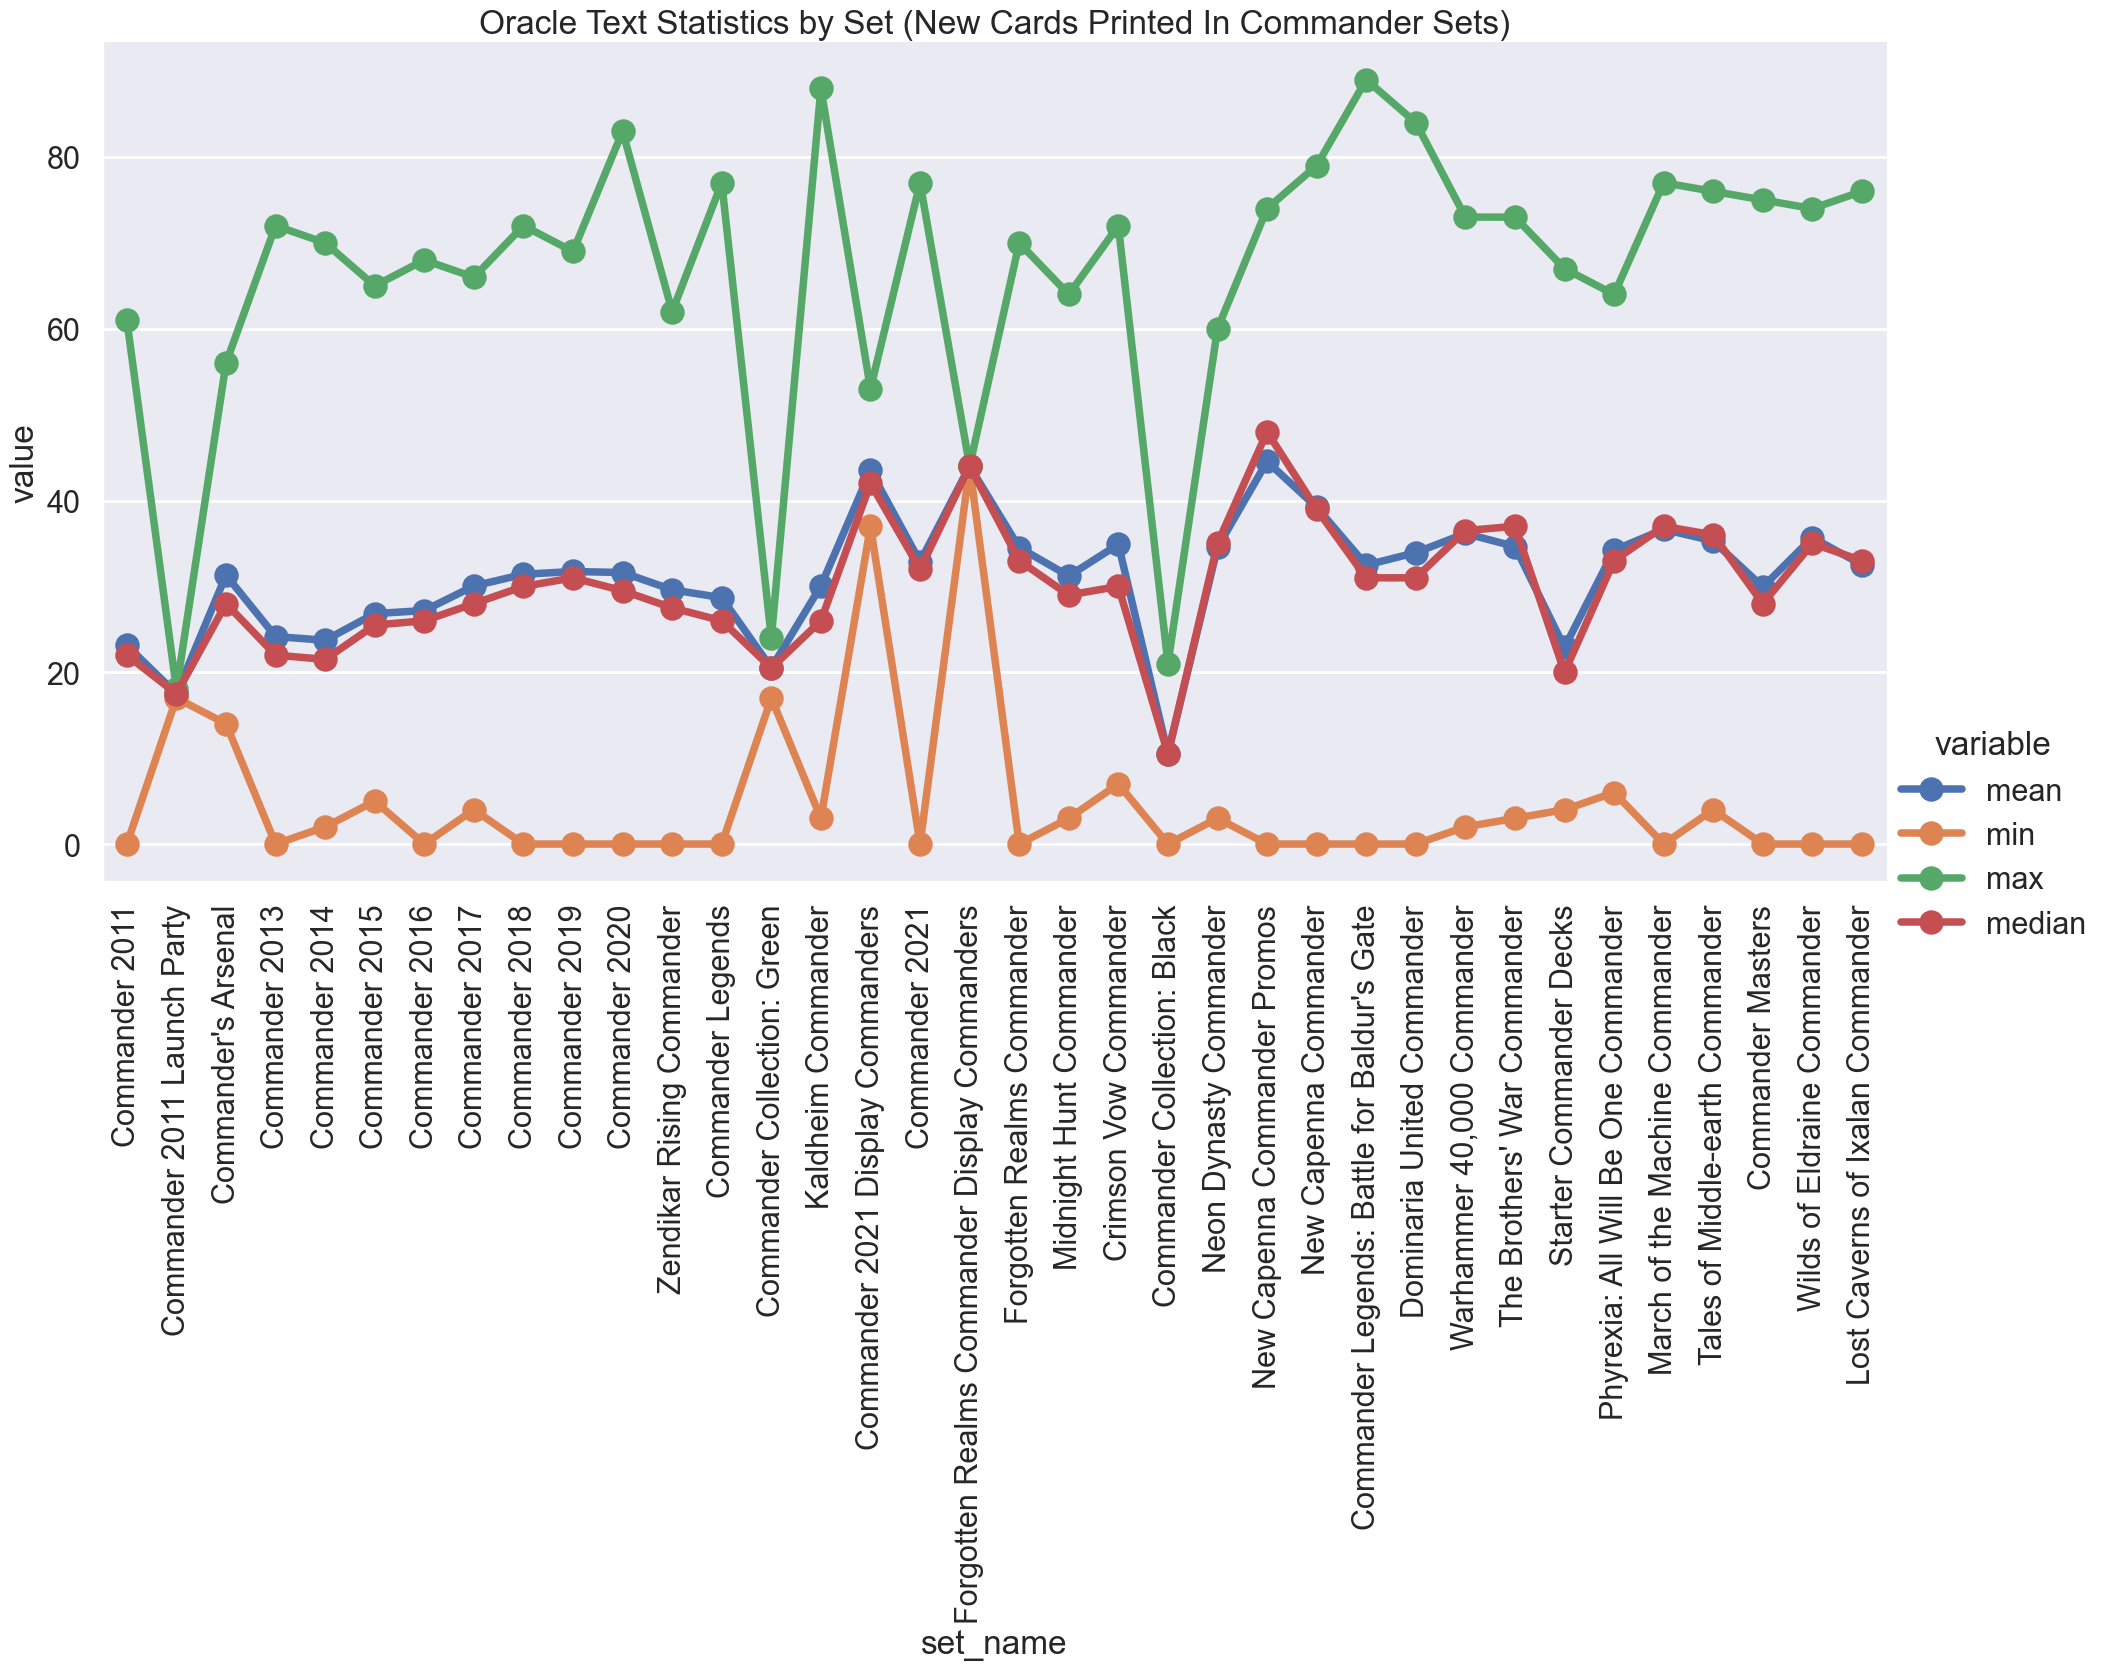

In [7]:
unique_commander_df.loc[:, 'released_at'] = pd.to_datetime(unique_commander_df['released_at'])
unique_commander_df.loc[:, 'year'] = unique_commander_df['released_at'].dt.year

# Group the data by 'year' and get the number of cards in each group
cards_per_year = unique_commander_df.groupby('year').size()

# Create a graph showing the number of cards per year
ax = cards_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Commander Cards per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')

# Add data labels to the bars
for i, v in enumerate(cards_per_year):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.show()


# Count the number of words in each oracle_text
unique_commander_df.loc[:, 'word_count'] = unique_commander_df['oracle_text'].apply(lambda x: len(str(x).split()))

# Group by set and year, and calculate mean, median, min, and max word count
stats = unique_commander_df.groupby(['set_name', 'year'])['word_count'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Reshape the DataFrame for easier plotting
melted_stats = stats.melt(id_vars=['set_name', 'year'], value_vars=['mean', 'median', 'min', 'max'])

# Create a bar plot with 'year' on the x-axis
sns.catplot(data=melted_stats, x='year', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.title('Oracle Text Statistics by Set (New Cards Printed In Commander Sets)')
plt.show()

# Merge 'released_at' back into the 'melted_stats' DataFrame
melted_stats = pd.merge(melted_stats, unique_commander_df[['set_name', 'year', 'released_at']].drop_duplicates(), on=['set_name', 'year'], how='left')

# Sort the DataFrame by 'released_at'
melted_stats_sorted = melted_stats.sort_values(by='released_at')

# Create a bar plot with 'set_name' on the x-axis
sns.catplot(data=melted_stats_sorted, x='set_name', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Oracle Text Statistics by Set (New Cards Printed In Commander Sets)')
plt.show()

# Print the names of sets released in 2011


C:\Users\edwar\AppData\Local\Temp\ipykernel_9824\131527137.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  commander_cards_df = unique_df[commander_players_stuff_filter]
C:\Users\edwar\AppData\Local\Temp\ipykernel_9824\131527137.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commander_cards_df['year'] = pd.to_datetime(commander_cards_df['released_at']).dt.year


Number of records in 'commander_cards' filter: 3773
Number of records in 'legendary_creatures' filter: 7469
Number of records in 'backgrounds' filter: 65
Number of records in 'planes_walker_cmdrs' filter: 86
Number of records in 'commander_players_stuff_filter' filter: 10784

['Scion of Halaster' 'Popular Entertainer' 'Far Traveler' 'Noble Heritage'
 'Inspiring Leader' 'Folk Hero' 'Hardy Outlander'
 'Agent of the Iron Throne' 'Faceless One' 'Dungeon Delver'
 'Raised by Giants' 'Cultist of the Absolute' 'Passionate Archaeologist'
 'Sword Coast Sailor' 'Acolyte of Bahamut' 'Guild Artisan'
 'Candlekeep Sage' 'Haunted One' 'Street Urchin' 'Feywild Visitor'
 'Flaming Fist' 'Cloakwood Hermit' 'Clan Crafter' 'Shameless Charlatan'
 'Criminal Past' 'Veteran Soldier' 'Dragon Cultist' 'Tavern Brawler'
 'Agent of the Shadow Thieves' 'Master Chef']
30
Total legendary cards: 3302


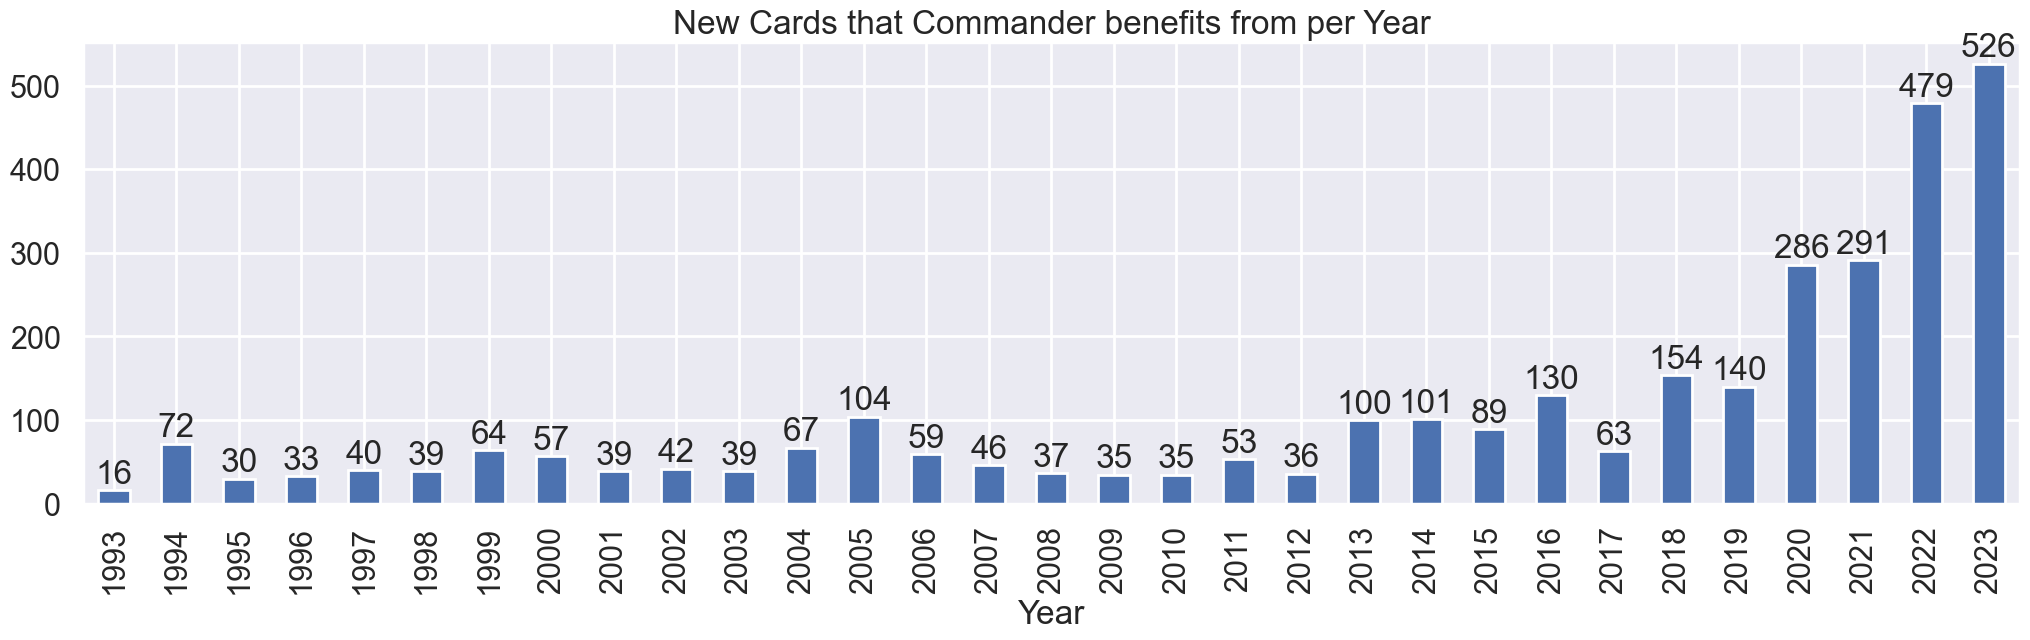

C:\Users\edwar\AppData\Local\Temp\ipykernel_9824\131527137.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  legendary_creatures_df = unique_df[valid_commander_filter]
C:\Users\edwar\AppData\Local\Temp\ipykernel_9824\131527137.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legendary_creatures_df['year'] = pd.to_datetime(legendary_creatures_df['released_at']).dt.year


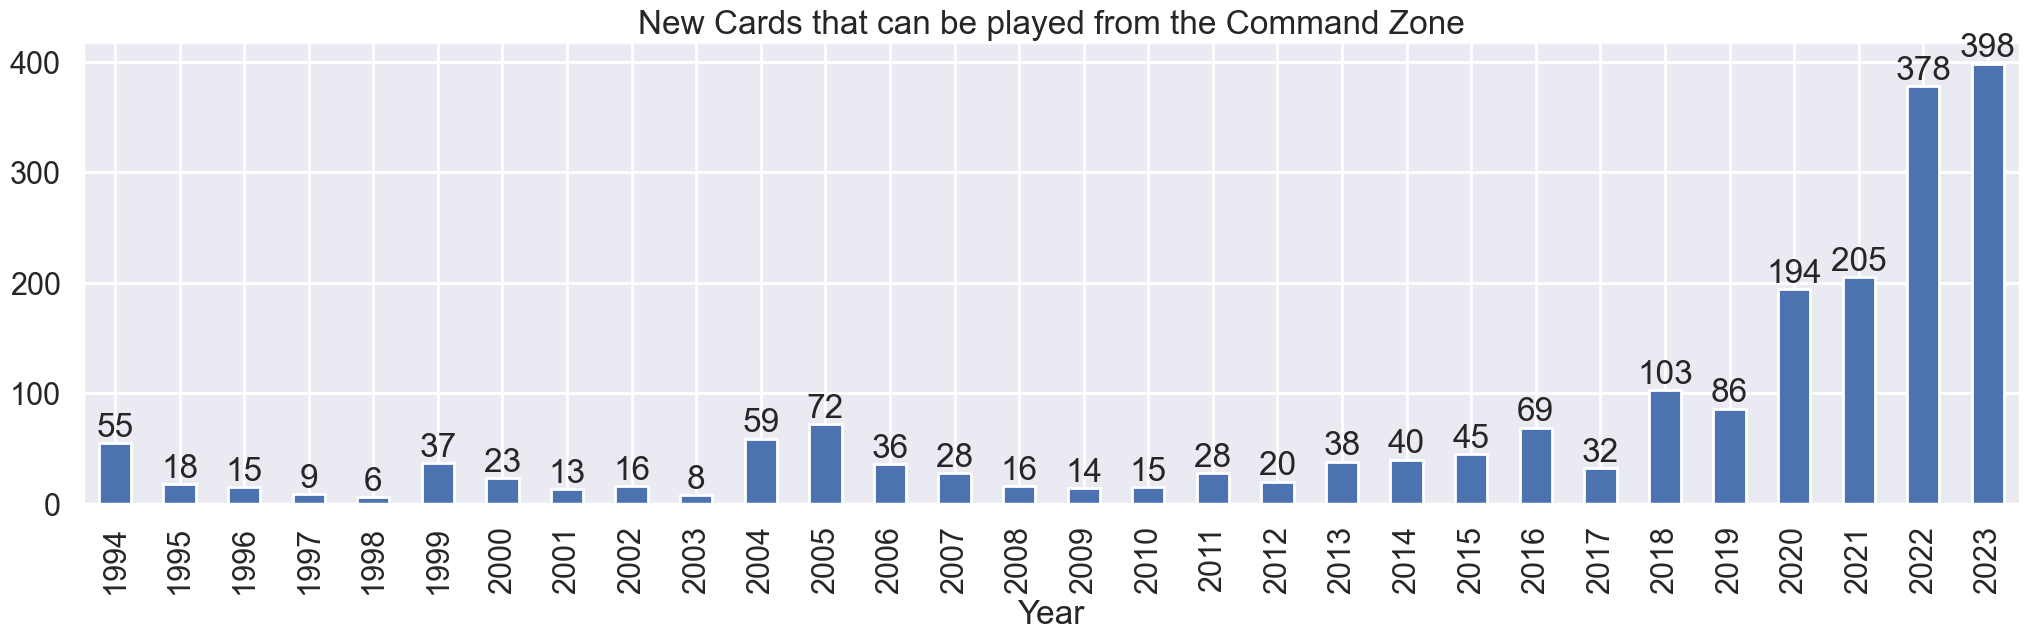

In [30]:
#Sort the values in descnding order then drop duplicates keeping the first one. This will keep only the oldest version of each card
df = df.sort_values(by='released_at', ascending=True)
unique_df = df.drop_duplicates(subset='name', keep='first')


# Filters for commander cards
commander_cards = df['oracle_text'].str.contains('each opponent', case=False, na=False) | df['oracle_text'].str.contains('each player', case=False, na=False)
legendary_creatures = df['type_line'].str.contains('legendary', case=False, na=False) & df['type_line'].str.contains('creature', case=False, na=False)
backgrounds = df['type_line'].str.contains('background', case=False, na=False)
planes_walker_cmdrs = df['oracle_text'].str.contains('can be your commander', case=False, na=False)

#Combine the filters into one
commander_players_stuff_filter = backgrounds | legendary_creatures | planes_walker_cmdrs | commander_cards

# Ensure that the boolean series has the same index as the DataFrame
commander_players_stuff_filter = commander_players_stuff_filter.reindex(unique_df.index)



#Use the filter to create a new DataFrame
commander_cards_df = unique_df[commander_players_stuff_filter]



# Use the filter to create a new DataFrame
commander_cards_df = unique_df.loc[commander_players_stuff_filter]

# Extract the Year from the 'released_at' datetime column
commander_cards_df.loc[:, 'year'] = pd.to_datetime(commander_cards_df['released_at']).dt.year




# Print the number of records in each filter - These are essentially to test the filters
# print(f"Number of records in 'commander_cards' filter: {commander_cards.sum()}")
# print(f"Number of records in 'legendary_creatures' filter: {legendary_creatures.sum()}")
# print(f"Number of records in 'backgrounds' filter: {backgrounds.sum()}")
# print(f"Number of records in 'planes_walker_cmdrs' filter: {planes_walker_cmdrs.sum()}")
# print(f"Number of records in 'commander_players_stuff_filter' filter: {commander_players_stuff_filter.sum()}")
# print()
# backgrounds_list = df[df['type_line'].str.contains('background', case=False, na=False)]['name'].unique()
# print(backgrounds_list)
# print(len(backgrounds_list))



#Extract the Year from the 'released_at' datetime column
commander_cards_df['year'] = pd.to_datetime(commander_cards_df['released_at']).dt.year

# Group the data by 'year' and get the number of cards in each group
commander_cards_per_year = commander_cards_df.groupby('year').size()

# Create a graph showing the number of cards per year
ax = commander_cards_per_year.plot(kind='bar', figsize=(25, 6))

plt.title('New Cards that Commander benefits from per Year')
plt.xlabel('Year')
#plt.ylabel('Number of Cards') # Don't need this label as it is in the title

# Add data labels to the bars
for i, v in enumerate(commander_cards_per_year):
    ax.text(i, v, str(v), ha='center', va='bottom')
print(f"Total legendary cards: {len(commander_cards_df)}")

plt.show()

#Look at legendary creatures only by creating a filter
valid_commander_filter = legendary_creatures | planes_walker_cmdrs | backgrounds

#create a new DataFrame with the filter
legendary_creatures_df = unique_df[valid_commander_filter]

#Extract the year from the 'released_at' datetime column
legendary_creatures_df['year'] = pd.to_datetime(legendary_creatures_df['released_at']).dt.year

#Group by year and get the number of cards in each group
legendary_creatures_per_year = legendary_creatures_df.groupby('year').size()

# Create a graph showing the number of cards per year
ax = legendary_creatures_per_year.plot(kind='bar', figsize=(25, 6))

plt.title('New Cards that can be played from the Command Zone')
plt.xlabel('Year')
#plt.ylabel('Number of Cards') # Don't need this label as it is in the title

# Add data labels to the bars
for i, v in enumerate(legendary_creatures_per_year):
    ax.text(i, v, str(v), ha='center', va='bottom')


plt.show()

In [ ]:
# Filter rows where 'type_line' contains "legendary"
commander_cards = df['oracle_text'].str.contains('each opponent', case=False, na=False)
commander_cards2 = df['oracle_text'].str.contains('each player', case=False, na=False)
legendary_creatures = df['type_line'].str.contains('legendary creature', case=False, na=False)
planes_walker_cmdrs = df['oracle_text'].str.contains('can be your commander', case=False, na=False)

commander_players_stuff = commander_cards | commander_cards2 | legendary_creatures | planes_walker_cmdrs

commander_cards_df = df[commander_players_stuff]    

commander_cards_df['year'] = pd.to_datetime(commander_cards_df['released_at']).dt.year

# Group the data by 'year' and get the number of cards in each group
commander_cards_per_year = commander_cards_df.groupby('year').size()

# Create a graph showing the number of cards per year
commander_cards_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Commander Cards per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')
plt.show()

print(f"Total legendary cards: {len(commander_cards_df)}")

#Look at legendary creatures only
valid_commander_filter = legendary_creatures | planes_walker_cmdrs
legendary_creatures_df = df[valid_commander_filter]

legendary_creatures_df['year'] = pd.to_datetime(legendary_creatures_df['released_at']).dt.year

#Group by year and get the number of cards in each group
legendary_creatures_per_year = legendary_creatures_df.groupby('year').size()

#Create a graph showing the number of cards per year
legendary_creatures_per_year.plot(kind='bar', figsize=(12,6))
plt.title('Number of Commanders per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')
plt.show()

In [9]:
#The name of Commanders from 1994
print(legendary_creatures_df[legendary_creatures_df['year']==1994]['name'].unique())
print(legendary_creatures_df[legendary_creatures_df['year']==1994])


['Ayesha Tanaka' 'Hunding Gjornersen' 'Barktooth Warbeard' 'Hazezon Tamar'
 'Vaevictis Asmadi' 'Tor Wauki' 'Lord Magnus' 'Arcades Sabboth' 'Ragnar'
 'Halfdane' 'Pavel Maliki' 'Sir Shandlar of Eberyn' 'Gabriel Angelfire'
 'Kasimir the Lone Wolf' 'Gwendlyn Di Corci' 'Rasputin Dreamweaver'
 'Angus Mackenzie' 'Sunastian Falconer' 'Torsten Von Ursus'
 'Adun Oakenshield' 'Marhault Elsdragon' 'Kei Takahashi' 'Nicol Bolas'
 "Sol'kanar the Swamp King" 'Jerrard of the Closed Fist' 'Ur-Drago'
 'Boris Devilboon' 'The Lady of the Mountain' 'Tetsuo Umezawa' 'Chromium'
 'Gosta Dirk' 'Jedit Ojanen' 'Sivitri Scarzam' 'Tuknir Deathlock'
 'Princess Lucrezia' 'Stangg' 'Axelrod Gunnarson' 'Palladia-Mors'
 'Lady Orca' 'Johan' 'Livonya Silone' 'Tobias Andrion' 'Xira Arien'
 'Riven Turnbull' 'Lady Caleria' 'Jasmine Boreal' 'Nebuchadnezzar'
 'Ramirez DePietro' 'Rohgahh of Kher Keep' 'Jacques le Vert'
 'Ramses Overdark' 'Rubinia Soulsinger' 'Bartel Runeaxe' 'Lady Evangela'
 'Dakkon Blackblade']
      object    

In [10]:
# Filter rows where 'type_line' contains "token"
df_token = df[df['type_line'].str.contains('token', case=False, na=False)]

# Print the unique 'type_line' values in these rows
print(len(df_token['type_line'].unique()))

59
